In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import torch

from sklearn.decomposition import FactorAnalysis as FA
from scipy.stats import special_ortho_group as sog
from scipy.optimize import minimize

from neuropacks import PVC11

from noise_correlations.analysis import generate_dimlets_and_stim_pairs, get_optimal_orientation
from noise_correlations.discriminability import lfi
from noise_correlations.utils import FACov, mean_cov, get_rotation_for_vectors

In [6]:
def plot_ellipse(mu, cov, ax, c='C0', alpha=.25, n_std=2, ec=None):
    e, v = np.linalg.eigh(cov)
    e = np.sqrt(e)
    ell = Ellipse(mu, 2*e[1]*n_std, 2*e[0]*n_std,
                  180. * np.arctan2(v[1, -1], v[0, -1]) / np.pi,
                  facecolor=c, alpha=.25, edgecolor=ec)
    ax.plot(mu[0], mu[1], 'o', c=c)
    ax.add_artist(ell)

In [7]:
pcv = PVC11('/storage/pvc11/spikes_gratings/data_monkey1_gratings.mat')

In [8]:
X = pcv.get_design_matrix(form='angle')
Y = pcv.get_response_matrix()
X.shape, Y.shape

((2400,), (2400, 106))

0.5305009306908158


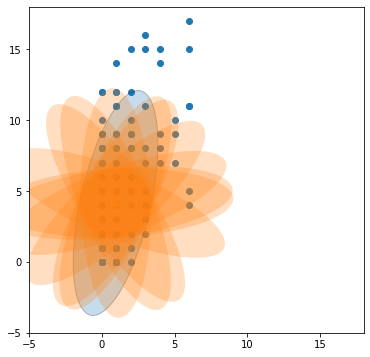

In [9]:
ni = 0
nj = 1
s = np.unique(X)[0]
idxs = np.equal(X, s)
Yi = Y[idxs][:, [ni, nj]]
print(np.corrcoef(Yi.T)[0, 1])

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(*Yi.T)
maxv = Yi.max()
ax.set_xlim(-5, maxv+1)
ax.set_ylim(-5, maxv+1)
mean = Yi.mean(axis=0)
cov = np.cov(Yi.T)
plot_ellipse(mean, cov, ax, ec='k')
for ii in range(10):
    R = sog(2).rvs()
    plot_ellipse(mean, R@cov@R.T, ax, c='C1', alpha=.05)

In [10]:
model = FA(n_components=1, tol=1e-8, svd_method='lapack')
model.fit(Yi)
print(model.loglike_[-1])
print(model.noise_variance_)
print(np.linalg.norm(cov - model.get_covariance()))

model = FA(n_components=1, tol=1e-8, svd_method='lapack', noise_variance_init=np.diag(cov))
model.fit(Yi)
print(model.loglike_[-1])
print(model.noise_variance_)
print(np.linalg.norm(cov - model.get_covariance()))

-884.1934617731154
[1.47302669 1.02082234]
0.08230865813517892
-884.1934617741462
[0.98947359 7.35284518]
0.08229523366678264


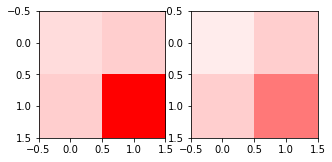

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(5, 10))
maxv = max(abs(np.cov(Yi.T)).max(), abs(model.components_.T @ model.components_).max())
axes[0].imshow(np.cov(Yi.T), cmap='bwr', vmin=-maxv, vmax=maxv)
axes[1].imshow(model.components_.T @ model.components_, cmap='bwr', vmin=-maxv, vmax=maxv)

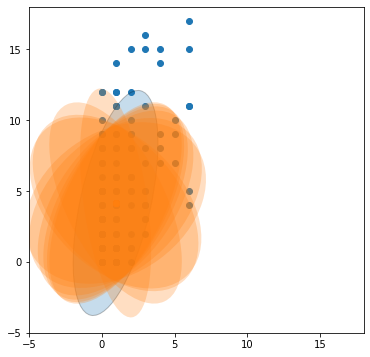

In [12]:
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(*Yi.T)
maxv = Yi.max()
ax.set_xlim(-5, maxv+1)
ax.set_ylim(-5, maxv+1)
mean = Yi.mean(axis=0)
cov = np.cov(Yi.T)
plot_ellipse(mean, cov, ax, ec='k')
for ii in range(10):
    R = sog(2).rvs()
    covp = np.diag(model.noise_variance_) + R @ model.components_.T @ model.components_ @ R.T
    plot_ellipse(mean, covp, ax, c='C1', alpha=.05)

In [ ]:
d = 18
ns = np.random.choice(np.arange(Y.shape[1]), replace=False, size=d)
s = np.unique(X)[0]
idxs = np.equal(X, s)
Yi = Y[idxs][:, ns]
cov = np.cov(Yi.T)

In [ ]:
Yi = np.random.randn(*Yi.shape) * np.arange(d)

In [ ]:
kmax = (d - 1) // 2
for k in range(1, kmax + 1):
    model = FA(n_components=k, tol=1e-8, svd_method='lapack',
               noise_variance_init=np.var(Yi, axis=0))
    model.fit(Yi)
    model0 = FA(n_components=k, tol=1e-8, svd_method='lapack')
    model0.fit(Yi)
    print(k, np.corrcoef(model.noise_variance_, model0.noise_variance_)[0, 1])

In [ ]:
model = FACov(Yi)
print(model.k)

In [ ]:
fig, axes = plt.subplots(3)
axes[0].imshow(cov)
axes[1].imshow(model.params()[1])
axes[2].imshow(model.params(sog.rvs(d))[1])

In [ ]:
for ii in range(1, 10):
    model = FA(n_components=ii, tol=1e-8, svd_method='lapack', noise_variance_init=np.diag(cov))
    model.fit(Yi)
    print(model.loglike_[-1])
    nv = model.noise_variance_
    print(nv)
    print(np.linalg.norm(cov - model.get_covariance()))
    model = FA(n_components=ii, tol=1e-8, svd_method='lapack')
    model.fit(Yi)
    print(model.loglike_[-1])
    print(model.noise_variance_)
    print(np.linalg.norm(cov - model.get_covariance()))
    plt.figure()
    plt.scatter(nv, model.noise_variance_)
    print()

In [ ]:
dims = np.arange(2, 20)
ks = np.arange(1, 10)
def n_params(n, k):
    ncov = (n**2 + n) // 2
    nfa = n + n*k
    return ncov, nfa

ncov, nfa = n_params(dims, 1)
plt.plot(dims, ncov, c='k', label='cov')
for ii, k in enumerate(ks):
    ds = dims[dims > k]
    ncov, nfa = n_params(ds, k)
    plt.scatter(ds, nfa, marker='x', c=f'C{ii}', label=r'FA$_{}$'.format(k))
plt.xticks(dims)
plt.legend(loc='best', ncol=2)
plt.xlabel('dim')
plt.ylabel('params')
plt.yscale('log')
plt.savefig('n_params.jpg', dpi=300)

# Dim-stims

In [ ]:
rng = np.random.RandomState(0)
k = 1
dim = 10
samples = 100
n_repeats = 100
units, stims = generate_dimlets_and_stim_pairs(Y.shape[1], X, dim, samples, rng,
                                               circular_stim=True)

lfis = np.zeros((units.shape[0], 2))
r_lfis = np.zeros((units.shape[0], 2, n_repeats))

for ii in range(units.shape[0]):
    if (ii % 10) == 0:
        print(float(ii) / units.shape[0])
    v_r_lfi, v_lfi = inner_calculate_nulls_measures_FA(Y, X, units[ii], stims[ii], rng,
                                                       k=k, n_repeats=n_repeats,
                                                       circular_stim=True)
    lfis[ii] = v_lfi
    r_lfis[ii] = v_r_lfi

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ii in range(3):
    v_r_lfi, v_lfi = r_lfis[ii], lfis[ii]
    bins = np.linspace(v_r_lfi.min(), v_r_lfi.max(), 100)
    axes[0, ii].hist(v_r_lfi[0], bins=bins, log=True)
    axes[0, ii].axvline(v_lfi[0], 0, 1, c='k')
    axes[0, ii].set_xlabel('Cov LFI')
    axes[0, ii].set_ylabel('Null counts')


    axes[1, ii].hist(v_r_lfi[1], bins=bins, log=True)
    axes[1, ii].axvline(v_lfi[1], 0, 1, c='k')
    axes[1, ii].set_xlabel(r'FA$_{}$ LFI'.format(k))
    axes[1, ii].set_ylabel('Null counts')

    bins = np.linspace(v_r_lfi[1].min(), v_r_lfi[1].max(), 100)
    axes[2, ii].hist(v_r_lfi[1], bins=bins, log=True)
    axes[2, ii].axvline(v_lfi[1], 0, 1, c='k')
    axes[2, ii].set_xlabel(r'FA$_{}$ LFI (zoom)'.format(k))
    axes[2, ii].set_ylabel('Null counts')
axes[0, 1].set_title(f'Dim: {dim}, k: {k}')
fig.tight_layout()
plt.savefig('cov_fa.jpg')

In [ ]:
# fig, ax = plt.subplots(1, figsize=(4, 4))
ps = np.mean(r_lfis <= lfis[..., np.newaxis], axis=-1)
bins = np.linspace(0, 1, 20)
ax.hist(ps[:, 0], bins=bins, histtype='step', label='cov', density=True)
ax.hist(ps[:, 1], bins=bins, histtype='step', label='fa', density=True)
ax.legend(loc='best')
ax.set_title(f'Dim: {dim}, k: {k}')
ax.set_xlabel('percentile')
ax.set_ylabel('density')
fig.tight_layout()
plt.savefig('cov_fa_ps.jpg')

# Optimal orientation

In [13]:
def make_cov(paramst, shared, private):
    dim = shared.shape[1]
    At = paramst.reshape(dim, dim)
    At = (At - At.t()) / 2.
    R = torch.matrix_exp(At)
    cov = torch.chain_matmul(R, shared.t(), shared, R.t()) + private
    return cov

def f_df(params, shared, private, mu0, mu1):
    paramst = torch.tensor(params, requires_grad=True)
    cov = make_cov(paramst, shared, private)
    loss = -lfi(mu0[np.newaxis], cov, mu1[np.newaxis], cov)
    loss.backward()
    loss = loss.detach().numpy()
    grad = paramst.grad.detach().numpy()
    return loss, grad

def optimize_FA(mu0, mu1, model):
    dim = model.shared.shape[1]
    shared = torch.tensor(model.shared)
    private = torch.tensor(np.diag(model.private))
    args = shared, private, torch.tensor(mu0), torch.tensor(mu1)
    x0 = np.zeros(dim**2)
    x = minimize(f_df, x0, method='L-BFGS-B', jac=True, args=args).x
    paramst = torch.tensor(x)
    cov = make_cov(paramst, shared, private).numpy()
    return cov

In [14]:
rng = np.random.RandomState(0)
dim = 20
samples = 1

units, stims = generate_dimlets_and_stim_pairs(Y.shape[1], X, dim, samples, rng,
                                               circular_stim=True)
x0 = stims[0][0]
Y0 = Y[X==x0][:, units[0]]
x1 = stims[0][1]
Y1 = Y[X==x1][:, units[0]]

In [15]:
mu0, cov0 = mean_cov(Y0)
mu1, cov1 = mean_cov(Y1)
Yall = np.concatenate([Y0 - mu0, Y1 - mu1], axis=0)
model = FACov(Yall)
_, cov01 = model.params()
print(model.private)

[ 6.38049288  0.46817894  6.95136641  0.087781   17.64218145 20.82489182
  6.21766074 12.66156908  2.87469771  2.57343083 19.20007556  0.94226558
  2.80123888 11.03903522  0.40256937  5.60298682 21.95467461  3.44308986
 13.06471815  7.07652267]


In [16]:
data_lfi = lfi(mu0, cov0, mu1, cov1)
_, opt_cov = get_optimal_orientation(mu0, mu1, cov0, cov1)
opt_lfi = lfi(mu0, opt_cov, mu1, opt_cov)
fa_lfi = lfi(mu0, cov01, mu1, cov01)
fa_opt_cov = optimize_FA(mu0, mu1, model)
fa_opt_lfi = lfi(mu0, fa_opt_cov, mu1, fa_opt_cov)
fa_opt_cov2 = model.get_optimal_orientation(mu0, mu1)
fa_opt_lfi2 = lfi(mu0, fa_opt_cov, mu1, fa_opt_cov)
print(data_lfi, opt_lfi, fa_lfi, fa_opt_lfi, fa_opt_lfi2)

24.542554641967357 5144.075709493709 24.620624784027108 47.92286286427054 47.92286286427054


In [19]:
samples = 1000
lfis = np.zeros((2, samples))
for ii in range(samples):
    R = sog.rvs(dim)
    lfis[0, ii] = lfi(mu0, R@cov0@R.T, mu1, R@cov1@R.T)
    _, covi = model.params(R)
    lfis[1, ii] = lfi(mu0, covi, mu1, covi)

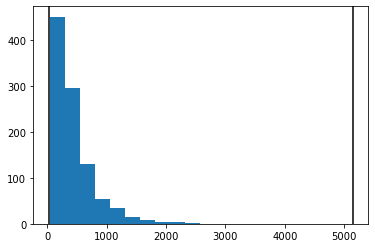

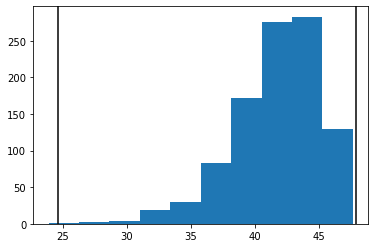

In [20]:
plt.hist(lfis[0], bins=10)
plt.axvline(data_lfi, 0, 1, c='k')
plt.axvline(opt_lfi, 0, 1, c='k')

plt.figure()
plt.hist(lfis[1], bins=10)
plt.axvline(fa_lfi, 0, 1, c='k')
plt.axvline(fa_opt_lfi, 0, 1, c='k')